# Figure 3

In [1]:
import os.path as op
import pandas as pd
import numpy as np
from scipy import interpolate, ndimage
import seaborn as sns
import matplotlib.pyplot as plt
import plotutils

In [2]:
df_dir = op.join('..', 'data', 'dataframes')

In [3]:
subjects, rois, tasks = plotutils.default_data()

In [4]:
plotutils.set_plot_style()

### Load dataframe

In [5]:
vert_df = pd.read_csv(op.join(df_dir, 'vertex_data.csv.gz'))

### Figure 3a

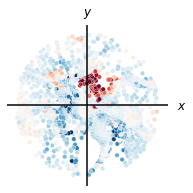

In [6]:
vdf = vert_df.query("subj=='wlsubj045' & task=='perception' & stim_angle_brain==45 & roi=='V1'")

with sns.axes_style("white"):
    g = sns.relplot(x='full-xcrds', y='full-ycrds', hue_norm=(-1.5, 1.5),
                    hue='beta', palette='RdBu_r', s=20, linewidth=.3, aspect=1, 
                    legend=False, height=3, data=vdf)
    
g.set(xlim=[-9, 9], ylim=[-9, 9], title='', xticks=[], yticks=[], xlabel='', ylabel='');
g.axes[0][0].axhline(y=0, c="0", lw=1.5)
g.axes[0][0].axvline(x=0, c="0", lw=1.5)
g.axes[0][0].text(10, -.5, "$\it{x}$", color="0", size=12)
g.axes[0][0].text(-.5, 10, "$\it{y}$", color="0", size=12)
sns.despine(trim=True, bottom=True, left=True)
plt.gcf().tight_layout()

### Figure 3b

In [7]:
def interpolate_activity(data, rois, subjects, stim_var='stim_angle_brain', val='beta', normalize=True):
    
    # Define stimulus space grid
    minval, maxval, stepval = [-8, 8, .125]
    x, y = np.mgrid[minval:maxval:stepval, minval:maxval:stepval]
    
    # Select data to plot
    data = data[data['subj'].isin(subjects)]
    data = data[data['roi'].isin(rois)]
    
    #Rotate coordinates
    rotate_x = lambda df: ( df['full-xcrds'] * np.cos(np.deg2rad(-1*df[stim_var])) + 
                            df['full-ycrds'] * np.sin(np.deg2rad(-1*df[stim_var])))
    rotate_y = lambda df: (-df['full-xcrds'] * np.sin(np.deg2rad(-1*df[stim_var])) + 
                            df['full-ycrds'] * np.cos(np.deg2rad(-1*df[stim_var])))
    data['rot-xcrds'] = data.apply(rotate_x, axis=1)
    data['rot-ycrds'] = data.apply(rotate_y, axis=1)

    df_cols = ['full-xcrds', 'full-ycrds', 'rot-xcrds', 'rot-ycrds', stim_var, val]
    
    # For each subject, model, and stimulus, get data, interpolate, and optionally normalize
    interp_df = []
    for (subj, task, ang), d in data.groupby(['subj', 'task', stim_var]):
        
        sd = d[df_cols].dropna()

        # Interpolate in actual space
        pts = sd[['full-xcrds', 'full-ycrds']].values
        vals = sd[val].values
        sinterp = interpolate.griddata(pts, vals, (x, y), method='linear', rescale=True).T
        if normalize:
            sinterp = (sinterp - np.nanmean(sinterp)) / np.nanstd(sinterp)
        
        # Interpolate in rotated space 
        pts = sd[['rot-xcrds', 'rot-ycrds']].values
        sinterp_rot = interpolate.griddata(pts, vals, (x, y), method='linear', rescale=True).T
        if normalize:
            sinterp_rot = (sinterp_rot - np.nanmean(sinterp_rot)) / np.nanstd(sinterp_rot)
        
        # Make dataframe
        sdf = pd.DataFrame(dict(subj=subj, task=task, stim_angle=ang, activity_map=sinterp.flatten(),
                                activity_map_rot=sinterp_rot.flatten(), inds=np.arange(len(sinterp.flatten()))))
        interp_df.append(sdf)
    interp_df = pd.concat(interp_df).reset_index(drop=True)
    
    return interp_df

In [8]:
def activity_heatmap(ax_data, g, vmax=1.5):
    
    # Plot heatmap on each axis
    for i, d in enumerate(ax_data):
        ax = g.axes.flatten()[i]
        sns.heatmap(np.reshape(d, (128, 128)), cbar=False, square=True, cmap='RdBu_r', 
                    vmin=-1*vmax, vmax=vmax, linewidths=0, cbar_kws={'ticks':[]}, ax=ax)
        ax.invert_yaxis()
        ax.set(xlim=[-4, 132], ylim=[-4, 132])
        ax.set_xticklabels(labels=[], rotation=0)
        ax.set_yticklabels(labels=[])
        ax.axhline(y=64, c="0")
        ax.axvline(x=64, c="0")
        ax.text(136, 64, "$\it{x}$", ha='left', va='center', color="0", size=12)
        ax.text(64, 136, "$\it{y}$", ha='center', va='bottom', color="0", size=12)
        
    sns.despine(trim=True, left=True, bottom=True)
    plt.gcf().tight_layout(h_pad=3)

In [9]:
def avg_activity_figure(interp_data, vmax=[1.5, 1.5]):
    
    # Average across subjects 
    dplot = interp_data.groupby(['task', 'inds'])['activity_map_rot'].aggregate(np.nanmedian).reset_index()
    
    # Create axes and get data for each facet
    with sns.axes_style("white"):
        g = sns.FacetGrid(row='task', row_order=['perception', 'memory'], 
                         height=3, aspect=1, sharex=False, data=interp_data)
    ax_data = []
    for i, d in g.facet_data():
        t = d['task'].iloc[0]
        ax_data.append(dplot.query("task==@t")['activity_map_rot'].values)
        
    # Plot heatmap on each facet
    activity_heatmap(ax_data, g, vmax=vmax)

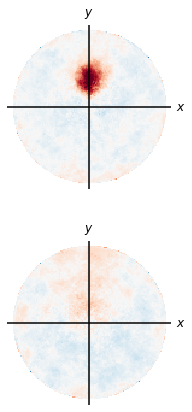

In [10]:
interp_v1 = interpolate_activity(vert_df, ['V1'], subjects)
avg_activity_figure(interp_v1, vmax=2.5)

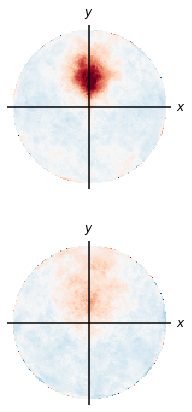

In [11]:
interp_v2 = interpolate_activity(vert_df, ['V2'], subjects)
avg_activity_figure(interp_v2, vmax=2.5)

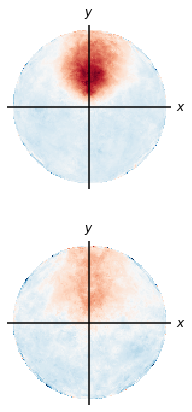

In [12]:
interp_v3 = interpolate_activity(vert_df, ['V3'], subjects)
avg_activity_figure(interp_v3, vmax=2.5)